# 2. Uproot

<br><br><br><br><br>

## What a ~complete analysis looks like in Uproot/Awkward Array

Instead of starting with small steps, let's look at where this is going, what a sample analysis looks like with these tools.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import awkward as ak

import uproot
import hist

In [2]:
upfile = uproot.open("root://eospublic.cern.ch//eos/opendata/cms/derived-data/AOD2NanoAODOutreachTool/Run2012BC_DoubleMuParked_Muons.root")
uptree = upfile["Events"]
uptree.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
nMuon                | uint32_t                 | AsDtype('>u4')
Muon_pt              | float[]                  | AsJagged(AsDtype('>f4'))
Muon_eta             | float[]                  | AsJagged(AsDtype('>f4'))
Muon_phi             | float[]                  | AsJagged(AsDtype('>f4'))
Muon_mass            | float[]                  | AsJagged(AsDtype('>f4'))
Muon_charge          | int32_t[]                | AsJagged(AsDtype('>i4'))


The general strategy is to get arrays in one function call (usually slow, has to read) and use them interactively afterward.

In [3]:
muons = uptree.arrays(["Muon_pt", "Muon_eta", "Muon_phi", "Muon_charge"], cut="nMuon >= 2", how="zip", entry_stop=100000)

In [4]:
muons

<Array [{Muon: [{pt: 10.8, ... charge: 1}]}] type='83343 * {"Muon": var * {"pt":...'>

We've already applied an `nMuon >= 2` cut, but we can define additional cuts.

In [5]:
os_cut = muons[:, "Muon", "charge", 0] != muons[:, "Muon", "charge", 1]
os_cut

<Array [False, True, False, ... True, True] type='83343 * bool'>

Slicing (to be described in more detail later) can remove data and reduce the structure of an array.

In [6]:
mu1 = muons[os_cut, 0, "Muon"]
mu2 = muons[os_cut, 1, "Muon"]
mu1, mu2

(<Array [{pt: 10.5, eta: -0.428, ... charge: 1}] type='60216 * {"pt": float32, "e...'>,
 <Array [{pt: 16.3, eta: 0.349, ... charge: -1}] type='60216 * {"pt": float32, "e...'>)

Make a histogram and fill it with a calculation from the array. The mini-plot is just the way this histogram type is visualized in Jupyter.

In [7]:
h1 = hist.Hist.new.Reg(120, 0, 120, name="mass").Double()

In [8]:
h1

Hist(Regular(120, 0, 120, name='mass', label='mass'), storage=Double())

In [9]:
h1.fill(np.sqrt(2*mu1.pt*mu2.pt*(np.cosh(mu1.eta - mu2.eta) - np.cos(mu1.phi - mu2.phi))))

Hist(Regular(120, 0, 120, name='mass', label='mass'), storage=Double()) # Sum: 59917.0 (60216.0 with flow)

Plot it using Matplotlib (for logscale).

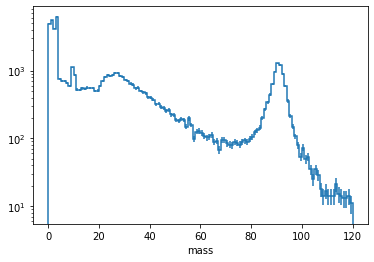

In [10]:
h1.plot()
plt.yscale("log")

<br><br><br><br><br>

## What a the same analysis looks like in PyROOT

In [11]:
import ROOT
c1 = ROOT.TCanvas()

Welcome to JupyROOT 6.22/08


In [12]:
rootfile = ROOT.TFile.Open("root://eospublic.cern.ch//eos/opendata/cms/derived-data/AOD2NanoAODOutreachTool/Run2012BC_DoubleMuParked_Muons.root")
roottree = rootfile.Get("Events")

ROOT analyses (before RDataFrame; see below) are based on an event loop. Reading and calculations are done in the loop.

This is not following the "one weird trick." That's why it's slow.

In [13]:
h2 = ROOT.TH1D("h2", "mass", 120, 0, 120)

for index, event in enumerate(roottree):
    # Analyzing a subsample means breaking out of the loop early.
    if index == 100000:
        break
    # Applying cuts means if-statements.
    if event.nMuon >= 2 and event.Muon_charge[0] != event.Muon_charge[1]:
        mu1_pt = event.Muon_pt[0]
        mu2_pt = event.Muon_pt[1]
        mu1_eta = event.Muon_eta[0]
        mu2_eta = event.Muon_eta[1]
        mu1_phi = event.Muon_phi[0]
        mu2_phi = event.Muon_phi[1]
        h2.Fill(np.sqrt(2*mu1_pt*mu2_pt*(np.cosh(mu1_eta - mu2_eta) - np.cos(mu1_phi - mu2_phi))))

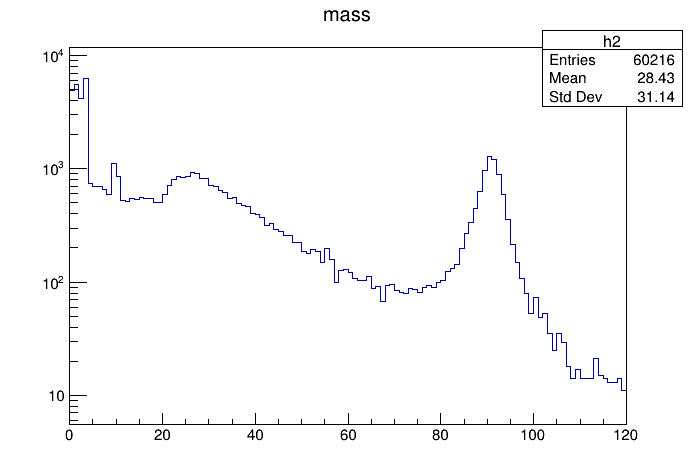

In [14]:
h2.Draw()
c1.SetLogy()
c1.Draw()

<br><br><br><br><br>

## What a the same analysis looks like in old C++

By "old C++," I mean `TTree::GetEntry`. This is also a reading + calculating loop over events.

Use `ROOT.gInterpreter.Declare` to define a C++ function in Python that we can use through PyROOT.

In [15]:
ROOT.gInterpreter.Declare('''
void compute(TH1D& h3, TTree& roottree) {
    UInt_t nMuon;
    float Muon_pt[50];
    float Muon_eta[50];
    float Muon_phi[50];
    int32_t Muon_charge[50];

    roottree.SetBranchStatus("*", 0);
    roottree.SetBranchStatus("nMuon", 1);
    roottree.SetBranchStatus("Muon_pt", 1);
    roottree.SetBranchStatus("Muon_eta", 1);
    roottree.SetBranchStatus("Muon_phi", 1);
    roottree.SetBranchStatus("Muon_charge", 1);

    roottree.SetBranchAddress("nMuon", &nMuon);
    roottree.SetBranchAddress("Muon_pt", Muon_pt);
    roottree.SetBranchAddress("Muon_eta", Muon_eta);
    roottree.SetBranchAddress("Muon_phi", Muon_phi);
    roottree.SetBranchAddress("Muon_charge", Muon_charge);
    
    for (int index = 0; index < 100000; index++) {
        roottree.GetEntry(index);
        if (nMuon >= 2 && Muon_charge[0] != Muon_charge[1]) {
            float mu1_pt = Muon_pt[0];
            float mu2_pt = Muon_pt[1];
            float mu1_eta = Muon_eta[0];
            float mu2_eta = Muon_eta[1];
            float mu1_phi = Muon_phi[0];
            float mu2_phi = Muon_phi[1];
            h3.Fill(sqrt(2*mu1_pt*mu2_pt*(cosh(mu1_eta - mu2_eta) - cos(mu1_phi - mu2_phi))));
        }
    }
}
''')

True

In [16]:
rootfile = ROOT.TFile.Open("root://eospublic.cern.ch//eos/opendata/cms/derived-data/AOD2NanoAODOutreachTool/Run2012BC_DoubleMuParked_Muons.root")
roottree = rootfile.Get("Events")

h3 = ROOT.TH1D("h3", "mass", 120, 0, 120)

ROOT.compute(h3, roottree)

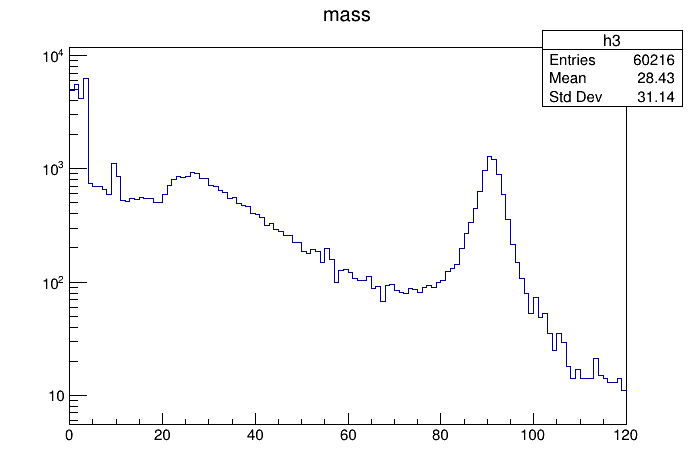

In [17]:
h3.Draw()
c1.SetLogy()
c1.Draw()

<br><br><br><br><br>

## What a the same analysis looks like in modern RDataFrame

This case mixes Python (for organization) with C++ (for speed).

<img src="img/rdataframe-flow.svg" style="width: 800px">

In [18]:
df = ROOT.RDataFrame("Events", "root://eospublic.cern.ch//eos/opendata/cms/derived-data/AOD2NanoAODOutreachTool/Run2012BC_DoubleMuParked_Muons.root")

# Each node is connected to the previous, in a chain (which can split and recombine).
df_limit = df.Range(100000)
df_2mu = df_limit.Filter("nMuon >= 2")
df_os = df_2mu.Filter("Muon_charge[0] != Muon_charge[1]")

# This node is a big C++ block.
df_mass = df_os.Define("Dimuon_mass", '''
float mu1_pt = Muon_pt[0];
float mu2_pt = Muon_pt[1];
float mu1_eta = Muon_eta[0];
float mu2_eta = Muon_eta[1];
float mu1_phi = Muon_phi[0];
float mu2_phi = Muon_phi[1];
return sqrt(2*mu1_pt*mu2_pt*(cosh(mu1_eta - mu2_eta) - cos(mu1_phi - mu2_phi)));
''')

# This one is an endpoint (action).
h4 = df_mass.Histo1D(("h3", "mass", 120, 0, 120), "Dimuon_mass")

The above just sets up the calculation (compiling the C++ strings). It runs when you evaluate `h4.Draw`.

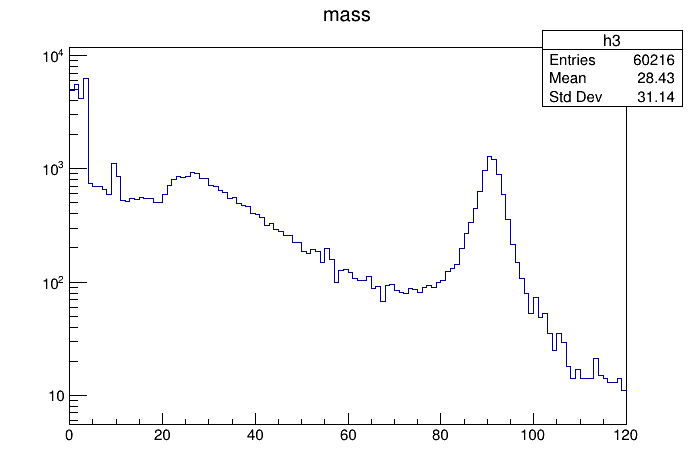

In [19]:
h4.Draw()   # <--- This is the line that computes everything.
c1.SetLogy()
c1.Draw()

For more on RDataFrame, see [this tutorial](https://cms-opendata-workshop.github.io/workshop-lesson-root/05-rdataframe/index.html).

<br><br><br><br><br>

## Ways to get data from Uproot

Uproot provides a rather low-level view into a ROOT file, so let's start with terminology.

All of the links below go to [the documentation](https://uproot.readthedocs.io/en/latest/).

<img src="img/terminology.svg" style="width: 800px">

<br><br><br>

### Navigating TDirectories

When you [open](https://uproot.readthedocs.io/en/latest/uproot.reading.open.html) a [TFile](https://uproot.readthedocs.io/en/latest/uproot.reading.ReadOnlyFile.html) in Uproot, you actually get a [TDirectory](https://uproot.readthedocs.io/en/latest/uproot.reading.ReadOnlyDirectory.html) object.

In [20]:
import numpy as np
import awkward as ak
import uproot

In [21]:
directory = uproot.open("data/nesteddirs.root")
directory

<ReadOnlyDirectory '/' at 0x7fad549617c0>

That's because it's the [TDirectory](https://uproot.readthedocs.io/en/latest/uproot.reading.ReadOnlyDirectory.html) that shows you all the objects that could be read.

You'll rarely need it, but the [TFile](https://uproot.readthedocs.io/en/latest/uproot.reading.ReadOnlyFile.html) itself is accessible from every object.

In [22]:
file = directory.file
file

<ReadOnlyFile 'data/nesteddirs.root' at 0x7fad54961880>

In [23]:
file.file_path

'data/nesteddirs.root'

In [24]:
file.root_version

'6.08/04'

In [25]:
file.uuid

UUID('ac63575a-9ca4-11e7-9607-0100007fbeef')

In [26]:
dir(file)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__enter__',
 '__eq__',
 '__exit__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_array_cache',
 '_begin_chunk',
 '_custom_classes',
 '_decompression_executor',
 '_fBEGIN',
 '_fCompress',
 '_fEND',
 '_fNbytesFree',
 '_fNbytesInfo',
 '_fNbytesName',
 '_fSeekFree',
 '_fSeekInfo',
 '_fUUID',
 '_fUUID_version',
 '_fUnits',
 '_fVersion',
 '_file_path',
 '_interpretation_executor',
 '_nfree',
 '_object_cache',
 '_options',
 '_source',
 '_streamer_rules',
 '_streamers',
 'array_cache',
 'begin_chunk',
 'chunk',
 'class_named',
 'close',
 'closed',
 'compression',
 'custom_classes',
 'decompression_executor',
 'detached',
 'fBEGIN',
 'fCompress',
 'fEND',
 'fNbytesFree',
 'fNbytesI

The [TDirectory](https://uproot.readthedocs.io/en/latest/uproot.reading.ReadOnlyDirectory.html) acts like a Python [Mapping](https://docs.python.org/3/library/collections.abc.html#collections.abc.Mapping), meaning that it has [keys](https://uproot.readthedocs.io/en/latest/uproot.reading.ReadOnlyDirectory.html#keys), [values](https://uproot.readthedocs.io/en/latest/uproot.reading.ReadOnlyDirectory.html#values), and [items](https://uproot.readthedocs.io/en/latest/uproot.reading.ReadOnlyDirectory.html#items), and you can get any value with `directory[key_name]`.

In [30]:
?directory.keys

Signature:
directory.keys(
    recursive=True,
    cycle=True,
    filter_name=<function no_filter at 0x7fad96045700>,
    filter_classname=<function no_filter at 0x7fad96045700>,
)
Docstring:
Args:
    recursive (bool): If True, descend into any nested subdirectories.
        If False, only return the names of objects directly accessible
        in this ``TDirectory``.
    cycle (bool): If True, include the cycle numbers in those names.
    filter_name (None, glob string, regex string in ``"/pattern/i"`` syntax, function of str → bool, or iterable of the above): A
        filter to select keys by name.
    filter_classname (None, glob string, regex string in ``"/pattern/i"`` syntax, function of str → bool, or iterable of the above): A
        filter to select keys by C++ (decoded) classname.

Returns the names of the objects in this ``TDirectory`` as a list of
strings.

Note that this does not read any data from the file.
File:      ~/irishep/uproot4/src/uproot/reading.py
Type:      m

In [27]:
directory["one"]

<ReadOnlyDirectory '/one' at 0x7fad4f110cd0>

In [31]:
directory["one/two/tree"]

<TTree 'tree' (20 branches) at 0x7fad4f163c70>

In [36]:
directory["one;1"]["two"]["tree"]

<TTree 'tree' (20 branches) at 0x7fad4f163c70>

In [33]:
directory.values()

[<ReadOnlyDirectory '/one' at 0x7fad4f110cd0>,
 <ReadOnlyDirectory '/one/two' at 0x7fad4f110160>,
 <TTree 'tree' (20 branches) at 0x7fad4f163c70>,
 <TTree 'tree' (3 branches) at 0x7fad54e836d0>,
 <ReadOnlyDirectory '/three' at 0x7fad4f110c40>,
 <TTree 'tree' (1 branches) at 0x7fad4f163e50>]

In [34]:
directory.items()

[('one;1', <ReadOnlyDirectory '/one' at 0x7fad4f110cd0>),
 ('one/two;1', <ReadOnlyDirectory '/one/two' at 0x7fad4f110160>),
 ('one/two/tree;1', <TTree 'tree' (20 branches) at 0x7fad4f163c70>),
 ('one/tree;1', <TTree 'tree' (3 branches) at 0x7fad54e836d0>),
 ('three;1', <ReadOnlyDirectory '/three' at 0x7fad4f110c40>),
 ('three/tree;1', <TTree 'tree' (1 branches) at 0x7fad4f163e50>)]

Since you'll likely want to find objects by class name without reading them, there's a fourth method: [classnames](https://uproot.readthedocs.io/en/latest/uproot.reading.ReadOnlyDirectory.html#classnames).

In [35]:
directory.classnames()

{'one;1': 'TDirectory',
 'one/two;1': 'TDirectory',
 'one/two/tree;1': 'TTree',
 'one/tree;1': 'TTree',
 'three;1': 'TDirectory',
 'three/tree;1': 'TTree'}

See the documentation; there are ways to filter the output. You might need that if you have a file with a lot of histograms in it.

In [37]:
directory.classnames(recursive=False)

{'one;1': 'TDirectory', 'three;1': 'TDirectory'}

In [39]:
directory.keys(filter_classname="TTree")

['one/two/tree;1', 'one/tree;1', 'three/tree;1']

<br><br><br>

### Generic objects

ROOT (probably) has thousands of classes. Uproot does not have specialized code to recognize them all.

However, most objects are readable anyway thanks to the [TStreamerInfo](https://uproot.readthedocs.io/en/latest/uproot.streamers.Model_TStreamerInfo.html) in every ROOT file. Here's one with custom classes that Uproot couldn't possibly know about.

In [40]:
directory = uproot.open("data/icecube-supernovae.root")
directory.classnames()

{'config;1': 'TDirectory',
 'config/analysis;1': 'SN_Analysis_Configuration_t',
 'config/detector;1': 'I3Eval_t',
 'config/run;1': 'SN_File_t',
 'sn_all;1': 'TTree',
 'sn_gps;1': 'TTree',
 'sn_range;1': 'TTree',
 'sn_o2rout;1': 'TTree',
 'sn_o2cand;1': 'TTree',
 'sn_omwatch;1': 'TTree',
 'sn_sigsim;1': 'TTree'}

The classes `SN_Analysis_Configuration_t`, `I3Eval_t`, `SN_File_t` were generated from the [TStreamerInfo](https://uproot.readthedocs.io/en/latest/uproot.streamers.Model_TStreamerInfo.html).

In [42]:
directory.streamer_of("config/detector")

<TStreamerInfo for I3Eval_t version 7 at 0x7fad4edd0dc0>

In [43]:
directory.file.show_streamers("I3Eval_t")

I3Eval_t::ChannelContainer_t (v1)

Sni3DataArray (v1)

TObject (v1)
    fUniqueID: unsigned int (TStreamerBasicType)
    fBits: unsigned int (TStreamerBasicType)

I3Eval_t (v7): TObject (v1)
    theDataArray: Sni3DataArray* (TStreamerObjectAnyPointer)
    NumberOfChannels: int (TStreamerBasicType)
    NoAvailableSlices: int (TStreamerBasicType)
    AvailableDataSize: int (TStreamerBasicType)
    mGPSCardId: int (TStreamerBasicType)
    mGPSPrescale: int (TStreamerBasicType)
    mGPSEventNo: int (TStreamerBasicType)
    mScalerCardId: int (TStreamerBasicType)
    mScalerStartChannel: int (TStreamerBasicType)
    StartUTC: long (TStreamerBasicType)
    MaxChannels: int (TStreamerBasicType)
    mMaxJitterLogs: int (TStreamerBasicType)
    Channel: I3Eval_t::ChannelContainer_t* (TStreamerObjectAnyPointer)
    ChannelIDMap: map<long,int> (TStreamerSTL)
    BadChannelIDSet: set<long> (TStreamerSTL)
    ChannelID: long* (TStreamerBasicPointer)
    Deadtime: double* (TStreamerBasicPointer)
   

You can read these objects, but they have no specialized methods and all members have to be accessed through [has_member](https://uproot.readthedocs.io/en/latest/uproot.model.Model.html#has-member)/[member](https://uproot.readthedocs.io/en/latest/uproot.model.Model.html#member)/[all_members](https://uproot.readthedocs.io/en/latest/uproot.model.Model.html#all-members).

In [41]:
directory["config/detector"]

<I3Eval_t (version 7) at 0x7fad4f109c40>

In [44]:
directory["config/detector"].all_members

{'@fUniqueID': 0,
 '@fBits': 50331648,
 'theDataArray': <Sni3DataArray (version 1) at 0x7fad4ece2a90>,
 'NumberOfChannels': 5160,
 'NoAvailableSlices': -1,
 'AvailableDataSize': 0,
 'mGPSCardId': 0,
 'mGPSPrescale': 20000000,
 'mGPSEventNo': 92824,
 'mScalerCardId': 0,
 'mScalerStartChannel': 0,
 'StartUTC': 272924620173109013,
 'MaxChannels': 5160,
 'mMaxJitterLogs': 20,
 'Channel': <I3Eval_t::ChannelContainer_t (version 1) at 0x7fad4ece2ca0>,
 'ChannelIDMap': <STLMap {46612627560: 896, ..., 281410180683757: 2689} at 0x7fad4ece2d00>,
 'BadChannelIDSet': <STLSet {58348614635591, 60068372029697, ..., 258905191174588} at 0x7fad4ece2f70>,
 'ChannelID': array([ 47303335284587,  20579555797555, 106634453247646, ...,
        255380957221937, 107432791511293, 280205879548048]),
 'Deadtime': array([250., 250., 250., ..., 250., 250., 250.]),
 'Efficiency': array([1.  , 1.  , 1.  , ..., 1.35, 1.35, 1.35])}

In [45]:
directory["config/detector"].member("ChannelIDMap")

<STLMap {46612627560: 896, ..., 281410180683757: 2689} at 0x7fad4ece2d00>

If a class has "Unknown" in its name or `isinstance(obj, (uproot.model.UnknownClass, uproot.model.UnknownClassVersion)`, that means that it could not be read.

(I don't know of any examples of that at the moment.)

<br><br><br>

### Histograms and graphs

Other classes have specialized interfaces, like histograms and some graphs. You can view the [axis](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TH1.TH1.html#axis) [edges](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TAxis.TAxis.html#edges) and the [values](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TH1.TH1.html#values), but this interface is minimal.

Normally, you'd convert

   * [to_numpy](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TH1.TH1.html#to-numpy): tuple of arrays (values and edges)
   * [to_boost](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TH1.TH1.html#to-boost): `boost_histogram` object
   * [to_hist](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TH1.TH1.html#to-hist): `hist` object (more fully featured subclass of `boost_histogram`)

In [46]:
directory = uproot.open("data/hepdata-example.root")
directory.classnames()

{'hpx;1': 'TH1F',
 'hpxpy;1': 'TH2F',
 'hprof;1': 'TProfile',
 'ntuple;1': 'TNtuple'}

In [47]:
directory["hpx"].to_numpy()

(array([2.000e+00, 3.000e+00, 1.000e+00, 1.000e+00, 2.000e+00, 4.000e+00,
        6.000e+00, 1.200e+01, 8.000e+00, 9.000e+00, 1.500e+01, 1.500e+01,
        3.100e+01, 3.500e+01, 4.000e+01, 6.400e+01, 6.400e+01, 8.100e+01,
        1.080e+02, 1.240e+02, 1.560e+02, 1.650e+02, 2.090e+02, 2.620e+02,
        2.970e+02, 3.920e+02, 4.320e+02, 4.660e+02, 5.210e+02, 6.040e+02,
        6.570e+02, 7.880e+02, 9.030e+02, 1.079e+03, 1.135e+03, 1.160e+03,
        1.383e+03, 1.458e+03, 1.612e+03, 1.770e+03, 1.868e+03, 1.861e+03,
        1.946e+03, 2.114e+03, 2.175e+03, 2.207e+03, 2.273e+03, 2.276e+03,
        2.329e+03, 2.325e+03, 2.381e+03, 2.417e+03, 2.364e+03, 2.284e+03,
        2.188e+03, 2.164e+03, 2.130e+03, 1.940e+03, 1.859e+03, 1.763e+03,
        1.700e+03, 1.611e+03, 1.459e+03, 1.390e+03, 1.237e+03, 1.083e+03,
        1.046e+03, 8.880e+02, 7.520e+02, 7.420e+02, 6.730e+02, 5.550e+02,
        5.330e+02, 3.660e+02, 3.780e+02, 2.720e+02, 2.560e+02, 2.000e+02,
        1.740e+02, 1.320e+02, 1.180e+0

In [48]:
directory["hpx"].to_hist()

Hist(Regular(100, -4, 4, name='xaxis', label='xaxis'), storage=Double()) # Sum: 74994.0 (75000.0 with flow)

In [49]:
directory["hpxpy"].to_hist()

Hist(
  Regular(40, -4, 4, name='xaxis', label='xaxis'),
  Regular(40, -4, 4, name='yaxis', label='yaxis'),
  storage=Double()) # Sum: 74985.0 (75000.0 with flow)

In [50]:
directory["hprof"].to_hist()

Hist(Regular(100, -4, 4, name='xaxis', label='xaxis'), storage=WeightedMean()) # Sum: WeightedMean(sum_of_weights=74993, sum_of_weights_squared=74993, value=2.00684, variance=1.97228) (WeightedMean(sum_of_weights=74998, sum_of_weights_squared=74998, value=2.0079, variance=1.989) with flow)

<br><br><br>

### TTrees

That's what you're here for, most likely.

In [51]:
directory = uproot.open("data/Zmumu.root")
directory.classnames()

{'events;1': 'TTree'}

In [52]:
events = directory["events"]
events.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
Type                 | char*                    | AsStrings()
Run                  | int32_t                  | AsDtype('>i4')
Event                | int32_t                  | AsDtype('>i4')
E1                   | double                   | AsDtype('>f8')
px1                  | double                   | AsDtype('>f8')
py1                  | double                   | AsDtype('>f8')
pz1                  | double                   | AsDtype('>f8')
pt1                  | double                   | AsDtype('>f8')
eta1                 | double                   | AsDtype('>f8')
phi1                 | double                   | AsDtype('>f8')
Q1                   | int32_t                  | AsDtype('>i4')
E2                   | double                   | AsDtype('>f8')
px2                  | double                   | AsDtype('>f

I've been advertising the above as a way to get a first look at a TTree, but you know you can get more detail through [keys](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TTree.TTree.html#keys), [typenames](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TTree.TTree.html#typenames), and [TBranch](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TBranch.TBranch.html) [interpretation](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TBranch.TBranch.html#interpretation).

In [53]:
events.keys()

['Type',
 'Run',
 'Event',
 'E1',
 'px1',
 'py1',
 'pz1',
 'pt1',
 'eta1',
 'phi1',
 'Q1',
 'E2',
 'px2',
 'py2',
 'pz2',
 'pt2',
 'eta2',
 'phi2',
 'Q2',
 'M']

In [54]:
events.keys(filter_typename="/int.*/")

['Run', 'Event', 'Q1', 'Q2']

In [55]:
events.typenames()

{'Type': 'char*',
 'Run': 'int32_t',
 'Event': 'int32_t',
 'E1': 'double',
 'px1': 'double',
 'py1': 'double',
 'pz1': 'double',
 'pt1': 'double',
 'eta1': 'double',
 'phi1': 'double',
 'Q1': 'int32_t',
 'E2': 'double',
 'px2': 'double',
 'py2': 'double',
 'pz2': 'double',
 'pt2': 'double',
 'eta2': 'double',
 'phi2': 'double',
 'Q2': 'int32_t',
 'M': 'double'}

In [56]:
{name: branch.interpretation for name, branch in events.items()}

{'Type': AsStrings(),
 'Run': AsDtype('>i4'),
 'Event': AsDtype('>i4'),
 'E1': AsDtype('>f8'),
 'px1': AsDtype('>f8'),
 'py1': AsDtype('>f8'),
 'pz1': AsDtype('>f8'),
 'pt1': AsDtype('>f8'),
 'eta1': AsDtype('>f8'),
 'phi1': AsDtype('>f8'),
 'Q1': AsDtype('>i4'),
 'E2': AsDtype('>f8'),
 'px2': AsDtype('>f8'),
 'py2': AsDtype('>f8'),
 'pz2': AsDtype('>f8'),
 'pt2': AsDtype('>f8'),
 'eta2': AsDtype('>f8'),
 'phi2': AsDtype('>f8'),
 'Q2': AsDtype('>i4'),
 'M': AsDtype('>f8')}

In [59]:
events.num_bytes

10011

<br><br><br>

### Get one array from one TBranch

This is the simplest method: [array](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TBranch.TBranch.html#array) (singular).

In [60]:
events["M"]

<TBranch 'M' at 0x7fad4e719c40>

In [64]:
events["M"].array(entry_stop=5)

<Array [82.5, 83.6, 83.3, 82.1, 90.5] type='5 * float64'>

Some important parameters:

   * `entry_start`, `entry_stop` to limit how much you read (if it's big)
   * `library="np"` for NumPy arrays, `library="ak"` for Awkward Arrays, and `library="pd"` for Pandas (Series or DataFrame)

In [65]:
events["M"].array(entry_stop=5)

<Array [82.5, 83.6, 83.3, 82.1, 90.5] type='5 * float64'>

In [67]:
events["M"].array(library="np")

array([82.46269156, 83.62620401, 83.30846467, ..., 95.96547966,
       96.49594381, 96.65672765])

In [68]:
events["M"].array(library="ak")   # default

<Array [82.5, 83.6, 83.3, ... 96, 96.5, 96.7] type='2304 * float64'>

In [70]:
events["M"].array(library="pandas")

0       82.462692
1       83.626204
2       83.308465
3       82.149373
4       90.469123
          ...    
2299    60.047138
2300    96.125376
2301    95.965480
2302    96.495944
2303    96.656728
Length: 2304, dtype: float64

<br><br><br>

### Get several TBranches as one array/array group

[TTrees](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TTree.TTree.html) and [TBranches](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TBranch.TBranch.html) with subbranches have an [arrays](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TBranch.HasBranches.html#arrays) (plural) method.

In [71]:
events.arrays()

<Array [{Type: 'GT', Run: 148031, ... M: 96.7}] type='2304 * {"Type": string, "R...'>

(Don't do that if your file is large.)

The return type is an "array group," which has a different meaning for each of the backends: NumPy, Awkward Array, and Pandas.

In [72]:
events.arrays(library="np")

{'Type': array(['GT', 'TT', 'GT', ..., 'TT', 'GT', 'GG'], dtype=object),
 'Run': array([148031, 148031, 148031, ..., 148029, 148029, 148029], dtype=int32),
 'Event': array([10507008, 10507008, 10507008, ..., 99991333, 99991333, 99991333],
       dtype=int32),
 'E1': array([82.20186639, 62.34492895, 62.34492895, ..., 81.27013558,
        81.27013558, 81.56621735]),
 'px1': array([-41.19528764,  35.11804977,  35.11804977, ...,  32.37749196,
         32.37749196,  32.48539387]),
 'py1': array([ 17.4332439 , -16.57036233, -16.57036233, ...,   1.19940578,
          1.19940578,   1.2013503 ]),
 'pz1': array([-68.96496181, -48.77524654, -48.77524654, ..., -74.53243061,
        -74.53243061, -74.80837247]),
 'pt1': array([44.7322, 38.8311, 38.8311, ..., 32.3997, 32.3997, 32.3997]),
 'eta1': array([-1.21769, -1.05139, -1.05139, ..., -1.57044, -1.57044, -1.57044]),
 'phi1': array([ 2.74126  , -0.440873 , -0.440873 , ...,  0.0370275,  0.0370275,
         0.0370275]),
 'Q1': array([ 1, -1, -1, ...

In [74]:
events.arrays(library="ak").type

2304 * {"Type": string, "Run": int32, "Event": int32, "E1": float64, "px1": float64, "py1": float64, "pz1": float64, "pt1": float64, "eta1": float64, "phi1": float64, "Q1": int32, "E2": float64, "px2": float64, "py2": float64, "pz2": float64, "pt2": float64, "eta2": float64, "phi2": float64, "Q2": int32, "M": float64}

In [75]:
events.arrays(library="pd")

,Type,Run,Event,E1,px1,py1,pz1,pt1,eta1,phi1,Q1,E2,px2,py2,pz2,pt2,eta2,phi2,Q2,M
0,GT,148031,10507008,82.201866,-41.195288,17.433244,-68.964962,44.7322,-1.217690,2.741260,1,60.621875,34.144437,-16.119525,-47.426984,38.8311,-1.051390,-0.440873,-1,82.462692
1,TT,148031,10507008,62.344929,35.118050,-16.570362,-48.775247,38.8311,-1.051390,-0.440873,-1,82.201866,-41.195288,17.433244,-68.964962,44.7322,-1.217690,2.741260,1,83.626204
2,GT,148031,10507008,62.344929,35.118050,-16.570362,-48.775247,38.8311,-1.051390,-0.440873,-1,81.582778,-40.883323,17.299297,-68.447255,44.7322,-1.217690,2.741260,1,83.308465
3,GG,148031,10507008,60.621875,34.144437,-16.119525,-47.426984,38.8311,-1.051390,-0.440873,-1,81.582778,-40.883323,17.299297,-68.447255,44.7322,-1.217690,2.741260,1,82.149373
4,GT,148031,105238546,41.826389,22.783582,15.036444,-31.689894,27.2981,-0.990688,0.583351,1,49.760726,-20.177373,-9.354149,44.513955,21.8913,1.444340,-2.707650,-1,90.469123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2299,GG,148029,99768888,32.701650,19.054651,14.833954,22.051323,24.1264,0.818806,0.661492,1,27.714554,-16.874052,-15.319644,-15.768964,22.8145,-0.645971,-2.404430,-1,60.047138
2300,GT,148029,99991333,168.780121,-68.041915,-26.105847,-152.235018,72.8781,-1.482700,-2.775240,-1,81.566217,32.485394,1.201350,-74.808372,32.3997,-1.570440,0.037027,1,96.125376
2301,TT,148029,99991333,81.270136,32.377492,1.199406,-74.532431,32.3997,-1.570440,0.037027,1,168.780121,-68.041915,-26.105847,-152.235018,72.8781,-1.482700,-2.775240,-1,95.965480
2302,GT,148029,99991333,81.270136,32.377492,1.199406,-74.532431,32.3997,-1.570440,0.037027,1,170.583132,-68.794136,-26.398400,-153.847604,72.8781,-1.482700,-2.775240,-1,96.495944


The first argument of this method takes a list of _expressions_, which could just be branch names:

In [76]:
events.arrays(["px1", "py1", "px2", "py2"], library="pd")

,px1,py1,px2,py2
0,-41.195288,17.433244,34.144437,-16.119525
1,35.118050,-16.570362,-41.195288,17.433244
2,35.118050,-16.570362,-40.883323,17.299297
3,34.144437,-16.119525,-40.883323,17.299297
4,22.783582,15.036444,-20.177373,-9.354149
...,...,...,...,...
2299,19.054651,14.833954,-16.874052,-15.319644
2300,-68.041915,-26.105847,32.485394,1.201350
2301,32.377492,1.199406,-68.041915,-26.105847
2302,32.377492,1.199406,-68.794136,-26.398400


Or it can be computed expressions.

In [77]:
events.arrays(["sqrt(px1**2 + py1**2)", "sqrt(px2**2 + py2**2)"], library="pd")

,sqrt(px1**2 + py1**2),sqrt(px2**2 + py2**2)
0,44.7322,37.7582
1,38.8311,44.7322
2,38.8311,44.3927
3,37.7582,44.3927
4,27.2981,22.2402
...,...,...
2299,24.1480,22.7909
2300,72.8781,32.5076
2301,32.3997,72.8781
2302,32.3997,73.6852


This is to support any [aliases](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TTree.TTree.html#aliases) that might be in the [TTree](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TTree.TTree.html), but you can make up your own `aliases` on the spot.

In [79]:
events.arrays(["pt1", "pt2"], {"pt1": "sqrt(px1**2 + py1**2)", "pt2": "sqrt(px2**2 + py2**2)"}, library="pd")

,pt1,pt2
0,44.7322,38.8311
1,38.8311,44.7322
2,38.8311,44.7322
3,38.8311,44.7322
4,27.2981,21.8913
...,...,...
2299,24.1264,22.8145
2300,72.8781,32.3997
2301,32.3997,72.8781
2302,32.3997,72.8781


The `expressions` parameter is not a good way to select branches by name.

   * nested branches, paths with "`/`", _would be interpreted as division!_
   * wildcards, paths with "`*`", _would be interpreted as multiplication!_

To select branches by name, use `filter_name`, `filter_typename`, `filter_branch` (all in the [arrays](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TBranch.HasBranches.html#arrays) documentation).

In [80]:
events.arrays(filter_name="p[xyz]*", library="pd")

,px1,py1,pz1,px2,py2,pz2
0,-41.195288,17.433244,-68.964962,34.144437,-16.119525,-47.426984
1,35.118050,-16.570362,-48.775247,-41.195288,17.433244,-68.964962
2,35.118050,-16.570362,-48.775247,-40.883323,17.299297,-68.447255
3,34.144437,-16.119525,-47.426984,-40.883323,17.299297,-68.447255
4,22.783582,15.036444,-31.689894,-20.177373,-9.354149,44.513955
...,...,...,...,...,...,...
2299,19.054651,14.833954,22.051323,-16.874052,-15.319644,-15.768964
2300,-68.041915,-26.105847,-152.235018,32.485394,1.201350,-74.808372
2301,32.377492,1.199406,-74.532431,-68.041915,-26.105847,-152.235018
2302,32.377492,1.199406,-74.532431,-68.794136,-26.398400,-153.847604


(These filters have the same meaning as in [keys](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TBranch.HasBranches.html#keys) and [typenames](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TBranch.HasBranches.html#typenames), but those methods do not read potentially large datasets.)

In [84]:
events.keys(filter_name=["p[xy]*", "pz*"])

['px1', 'py1', 'pz1', 'px2', 'py2', 'pz2']

In [82]:
events.typenames(filter_name="p[xyz]*")

{'px1': 'double',
 'py1': 'double',
 'pz1': 'double',
 'px2': 'double',
 'py2': 'double',
 'pz2': 'double'}

<br><br><br>

### Get arrays in manageable chunks

The [iterate](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TBranch.HasBranches.html#iterate) method is like [arrays](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TBranch.HasBranches.html#arrays), but it can be used in a loop over chunks of the array.

How large are the chunks? You should set that with `step_size`.

In [85]:
for arrays in events.iterate(step_size=300):
    print(repr(arrays))

<Array [{Type: 'GT', Run: 148031, ... M: 91.2}] type='300 * {"Type": string, "Ru...'>
<Array [{Type: 'GT', Run: 148031, ... M: 93.6}] type='300 * {"Type": string, "Ru...'>
<Array [{Type: 'GT', Run: 148031, ... M: 91.8}] type='300 * {"Type": string, "Ru...'>
<Array [{Type: 'TT', Run: 148031, ... M: 94.2}] type='300 * {"Type": string, "Ru...'>
<Array [{Type: 'TT', Run: 148031, ... M: 92.9}] type='300 * {"Type": string, "Ru...'>
<Array [{Type: 'GT', Run: 148031, ... M: 87.7}] type='300 * {"Type": string, "Ru...'>
<Array [{Type: 'TT', Run: 148029, ... M: 81.1}] type='300 * {"Type": string, "Ru...'>
<Array [{Type: 'TT', Run: 148029, ... M: 96.7}] type='204 * {"Type": string, "Ru...'>


In [86]:
for arrays in events.iterate(step_size="50 kB"):   # 50 kB is very small! for illustrative purposes only!
    print(repr(arrays))

<Array [{Type: 'GT', Run: 148031, ... M: 89.6}] type='667 * {"Type": string, "Ru...'>
<Array [{Type: 'TT', Run: 148031, ... M: 18.1}] type='667 * {"Type": string, "Ru...'>
<Array [{Type: 'GT', Run: 148031, ... M: 94.7}] type='667 * {"Type": string, "Ru...'>
<Array [{Type: 'GT', Run: 148029, ... M: 96.7}] type='303 * {"Type": string, "Ru...'>


<br><br><br>

### Collections of files (like TChain)

If you want to read a bunch of files in one call, it has to be a function, rather than a method of [TTree](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TTree.TTree.html).

   * The equivalent of [TTree](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TTree.TTree.html) [arrays](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TTree.TTree.html#arrays) is [uproot.concatenate](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TBranch.concatenate.html). _(Reads everything at once: use this as a convenience on datasets you know are small!)_
   * The equivalent of [TTree](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TTree.TTree.html) [iterate](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TTree.TTree.html#iterate) is [uproot.iterate](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TBranch.iterate.html). _(This is the most useful one.)_
   * There's also an [uproot.lazy](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TBranch.lazy.html) _(More on this below.)_

In [87]:
import IPython
import matplotlib.pyplot as plt
import matplotlib.pylab

import hist

KeyboardInterrupt: 

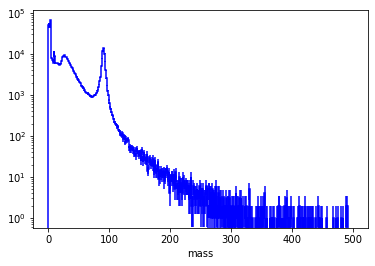

In [88]:
h1 = hist.Hist.new.Reg(500, 0, 500, name="mass").Double()
drawables = []

for muons in uproot.iterate(
    # filename(s)
    ["root://eospublic.cern.ch//eos/opendata/cms/derived-data/AOD2NanoAODOutreachTool/Run2012BC_DoubleMuParked_Muons.root:Events"],

    # branches to read as expressions
    ["Muon_pt", "Muon_eta", "Muon_phi", "Muon_charge"],

    # cut to apply to expressions
    cut="nMuon >= 2",

    # library dependent; for library="ak", try to split branch names at underscore and make nested records (poor man's NanoEvents)
    how="zip",

    # the all-important step_size!
    step_size="1 MB",

    # options you would normally pass to uproot.open
    xrootd_handler=uproot.MultithreadedXRootDSource,
    num_workers=10,
):
    # do everything you're going to do to this array
    os_cut = muons[:, "Muon", "charge", 0] != muons[:, "Muon", "charge", 1]
    mu1 = muons[os_cut, 0, "Muon"]
    mu2 = muons[os_cut, 1, "Muon"]

    # such as filling a histogram
    h1.fill(np.sqrt(2*mu1.pt*mu2.pt*(np.cosh(mu1.eta - mu2.eta) - np.cos(mu1.phi - mu2.phi))))

    # a little magic to animate it; hardest part is removing the previous plots
    for drawable in drawables:
        drawable.stairs.remove()
        drawable.errorbar.remove()
        drawable.legend_artist.remove()
    drawables = h1.plot(color="blue")
    plt.yscale("log")
    IPython.display.display(matplotlib.pylab.gcf())
    IPython.display.clear_output(wait=True)

<br><br><br>

### Lazy arrays

Lazy arrays were introduced so that you can explore a large dataset without knowing ahead of time what parts you're going to read.

In [89]:
events = uproot.lazy(
    # filename(s)
    ["root://eospublic.cern.ch//eos/opendata/cms/derived-data/AOD2NanoAODOutreachTool/Run2012BC_DoubleMuParked_Muons.root:Events"],
    # step_size is still important
    step_size="1 MB",
)
events

<Array [{nMuon: 2, Muon_pt: [10.8, ... -1, 1]}] type='61540413 * {"nMuon": uint3...'>

In [90]:
events.type

61540413 * {"nMuon": uint32, "Muon_pt": var * float32, "Muon_eta": var * float32, "Muon_phi": var * float32, "Muon_mass": var * float32, "Muon_charge": var * int32}

In [91]:
len(events)

61540413

It _looks like_ we've read that big remote file.

But actually (if we peek in the lazy array's cache), we've only read 3 TBaskets.

In [92]:
events._caches[0].keys()

['b0aab1f0-7ab5-11e9-8e62-0101007fbeef:/Events;75:nMuon(0):AsDtype(Bu4(),Lu4()):0-27433:ak',
 'b0aab1f0-7ab5-11e9-8e62-0101007fbeef:/Events;75:Muon_charge(5):AsJagged(AsDtype(Bi4(),Li4()),0):61532219-61540413:ak',
 'b0aab1f0-7ab5-11e9-8e62-0101007fbeef:/Events;75:Muon_pt(1):AsJagged(AsDtype(Bf4(),Lf4()),0):0-27433:ak']

In [93]:
events.Muon_pt

<Array [[10.8, 15.7], [10.5, ... [27.7, 20]] type='61540413 * var * float32'>

Now 4 TBaskets...

In [94]:
events._caches[0].keys()

['b0aab1f0-7ab5-11e9-8e62-0101007fbeef:/Events;75:nMuon(0):AsDtype(Bu4(),Lu4()):0-27433:ak',
 'b0aab1f0-7ab5-11e9-8e62-0101007fbeef:/Events;75:Muon_charge(5):AsJagged(AsDtype(Bi4(),Li4()),0):61532219-61540413:ak',
 'b0aab1f0-7ab5-11e9-8e62-0101007fbeef:/Events;75:Muon_pt(1):AsJagged(AsDtype(Bf4(),Lf4()),0):0-27433:ak',
 'b0aab1f0-7ab5-11e9-8e62-0101007fbeef:/Events;75:Muon_pt(1):AsJagged(AsDtype(Bf4(),Lf4()),0):61532219-61540413:ak']

<div style="font-size: 25px; margin: 10px; padding: 30px; border: 1px dashed black;">
    Big important warning: <b>this access pattern is not read or memory efficient!</b>
</div>

This pattern is much better for exploration, to compute quantities without having to decide ahead of time which branches you'll need.

**Recommendation:** develop with lazy arrays, but then put the calculation into an [iterate](https://uproot.readthedocs.io/en/latest/uproot.behaviors.TBranch.iterate.html) loop or a [Coffea Processor](https://coffeateam.github.io/coffea/notebooks/processor.html).